In [51]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.power import TTestIndPower

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# Задача
На сайте запущен А/В тест с целью увеличить доход. \
В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.\
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.


### Подготовка данных

In [31]:
df = pd.read_excel('AB_Test_Results.xlsx')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


#### Избавимся от некорректных строк, т.е удалим пользователей, которые попали в обе группы 

In [33]:
duplicates = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
duplicates = duplicates[duplicates]
df = df[df['USER_ID'].isin(duplicates.index)]
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [34]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

### Анализ данных

In [35]:
df.describe()

,USER_ID,REVENUE
count,6070.000000,6070.000000
mean,4983.664086,0.107064
std,2897.990118,2.673501
min,2.000000,0.000000
25%,2472.250000,0.000000
50%,4950.000000,0.000000
75%,7501.000000,0.000000
max,9998.000000,196.010000


In [36]:
df.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    3044
control    3026
Name: count, dtype: int64

In [37]:
df[df['REVENUE']>0]

,USER_ID,VARIANT_NAME,REVENUE
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
333,8020,control,9.91
...,...,...,...
9466,6623,control,1.78
9612,1035,control,0.23
9651,9928,variant,1.25
9711,6468,control,2.93


Посмотрим на группы отдельно

In [38]:
df[df['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,3026.000000,3026.000000
mean,4990.392928,0.155506
std,2919.665981,3.708620
min,2.000000,0.000000
25%,2457.750000,0.000000
50%,4949.500000,0.000000
75%,7603.750000,0.000000
max,9998.000000,196.010000


In [39]:
df[df['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,3044.000000,3044.000000
mean,4976.975033,0.058909
std,2876.744694,0.760344
min,4.000000,0.000000
25%,2487.250000,0.000000
50%,4950.000000,0.000000
75%,7376.500000,0.000000
max,9995.000000,23.040000


Сводная статистика

In [40]:
df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                    'REVENUE': ['max', 'mean','sum', 'count']})

USER_ID REVENUE                        
             nunique     max      mean     sum count
VARIANT_NAME                                        
control         2390  196.01  0.155506  470.56  3026
variant         2393   23.04  0.058909  179.32  3044

Контрольная группа показывает себя лучше тестовой

### Проверка на нормальность распределения и применение статистических критериев

#### Графики

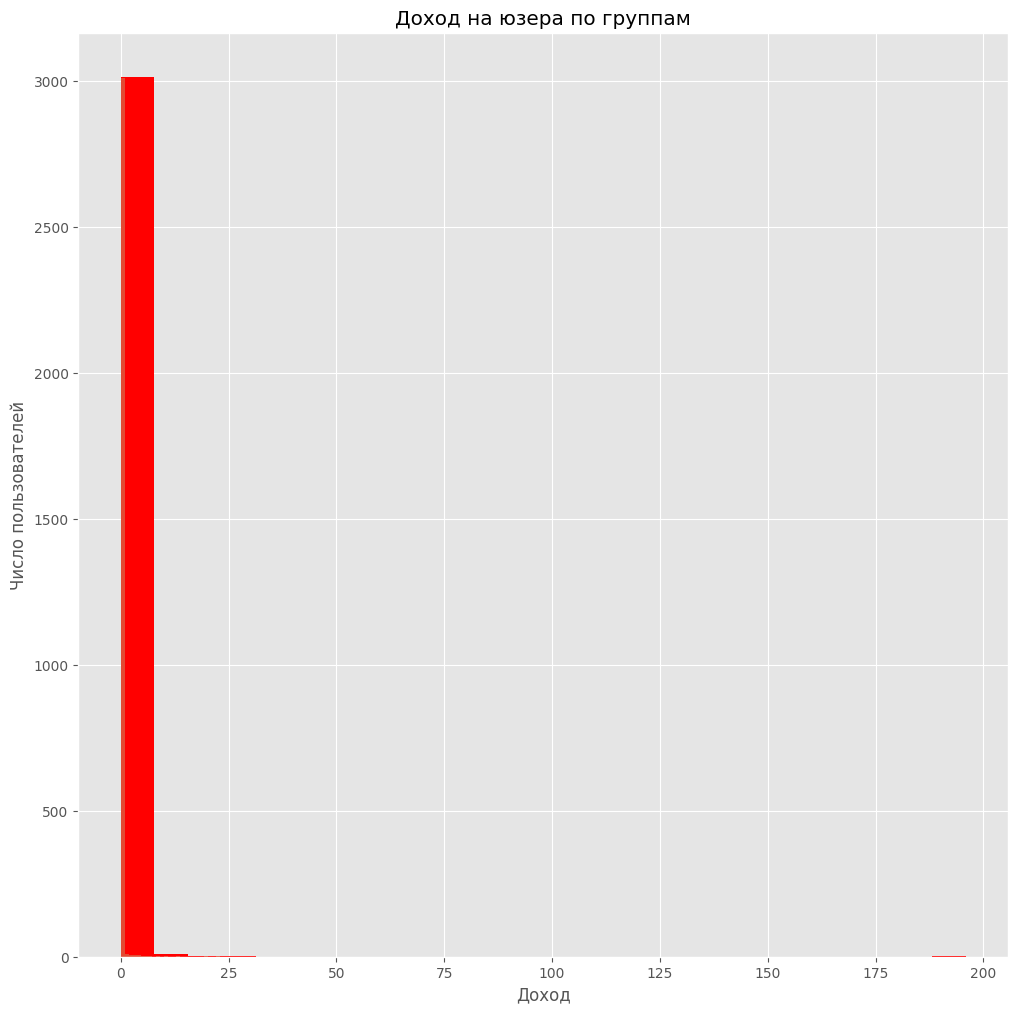

In [41]:
plt.figure(figsize=(12, 12))
control_visit_all = df['REVENUE'][df['VARIANT_NAME']=='control']
test_visit_all = df['REVENUE'][df['VARIANT_NAME']=='variant']

plt.hist(control_visit_all, color='r', bins=25)
plt.hist(test_visit_all, bins=25)
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')

plt.show()

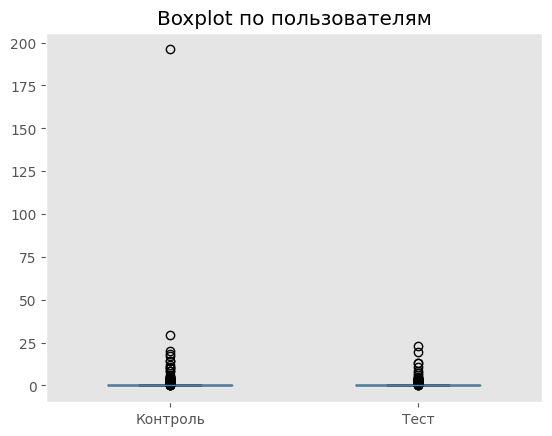

In [42]:
plt.boxplot([control_visit_all, test_visit_all],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [43]:
stats.ttest_ind(control_visit_all, test_visit_all, equal_var = False)

Ttest_indResult(statistic=1.403762252371675, pvalue=0.1604844017690842)

In [44]:
# добавим доп столбец для следующих расчетов

df['PURCHASE'] = df['REVENUE'].apply(lambda x: x>0)
df.head()

,USER_ID,VARIANT_NAME,REVENUE,PURCHASE
0,737,variant,0.0,False
4,6174,variant,0.0,False
5,2380,variant,0.0,False
7,9168,control,0.0,False
9,7548,control,0.0,False


In [45]:
k1 = df[df['VARIANT_NAME']=='control']['PURCHASE'].sum()
k2 = df[df['VARIANT_NAME']=='variant']['PURCHASE'].sum()

print(k1, k2)

54 43


In [46]:
n1 = df[df['VARIANT_NAME']=='control'].shape[0]
n2 = df[df['VARIANT_NAME']=='variant'].shape[0]

print(n1, n2)

3026 3044


In [47]:
# Z-тест
z_score, z_pvalue = proportions_ztest(np.array([k1, k2]), np.array([n1, n2]))
print('Результаты:','z_score = %.3f, pvalue = %.3f'%(z_score, z_pvalue))

if abs(z_pvalue) > 0.05:
   print('Нулевая гипотеза - Между конверсией в двух группах нет статистически значимых различий')
else:
   print('Альтернативная гипотеза – Между конверсией в двух группах есть статистически значимые различия')

Результаты: z_score = 1.155, pvalue = 0.248
Нулевая гипотеза - Между конверсией в двух группах нет статистически значимых различий


In [48]:
# Хи-квадрат
chisq, pvalue, table = proportions_chisquare(np.array([k1, k2]), np.array([n1, n2]))
print('Результаты:','chisq = %.3f, pvalue = %.3f'%(chisq, pvalue))

if abs(pvalue) > 0.05:
   print('Нулевая гипотеза - Между конверсией в двух группах нет статистически значимых различий')
else:
   print('Альтернативная гипотеза – Между конверсией в двух группах есть статистически значимые различия')

Результаты: chisq = 1.335, pvalue = 0.248
Нулевая гипотеза - Между конверсией в двух группах нет статистически значимых различий


#### Метрика arpu

In [49]:
# непараметрический критерий Манн-Уитни
mw_stats = stats.mannwhitneyu(x=df[(df['VARIANT_NAME'] == 'control')&(df['REVENUE'] > 0)]['REVENUE'].values,
                                                  y=df[(df['VARIANT_NAME'] == 'variant')&(df['REVENUE'] > 0)]['REVENUE'].values)

mw_stats
#ARPPU - средняя выручка на платящих users
# 4+5+6/3

MannwhitneyuResult(statistic=1292.0, pvalue=0.3431833825117172)

In [50]:
mw_stats = stats.mannwhitneyu(x=df[(df['VARIANT_NAME'] == 'control')]['REVENUE'].values,
                                                  y=df[(df['VARIANT_NAME'] == 'variant')]['REVENUE'].values)

mw_stats
#ARPU - средняя выручка на всех users
# 0+4+5+0+6+0/6

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

### Решение с помощью Bootstrap

Гипотезы:  
  
H0: Набор статистически значимо не влияет (p-value > 0.05)  
H1: Набор статистически значимо влияет (p-value < 0.05)  

In [27]:
from tqdm.auto import tqdm #для красивой полоски

plt.style.use('ggplot')

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

c:\Python 3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 10000/10000 [00:01<00:00, 7411.32it/s]


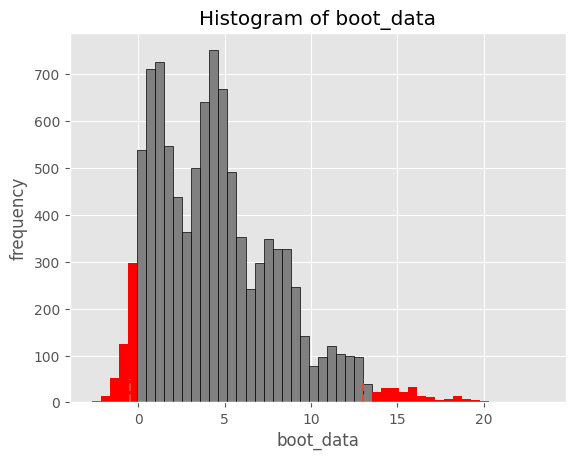

{'p_value': 0.21565851717102746}

In [28]:
get_bootstrap(df[(df['VARIANT_NAME'] == 'control')&(df['PURCHASE'] == True)]['REVENUE'], df[(df['VARIANT_NAME'] == 'variant')&(df['PURCHASE'] == True)]['REVENUE'])

100%|██████████| 10000/10000 [00:02<00:00, 4025.22it/s]


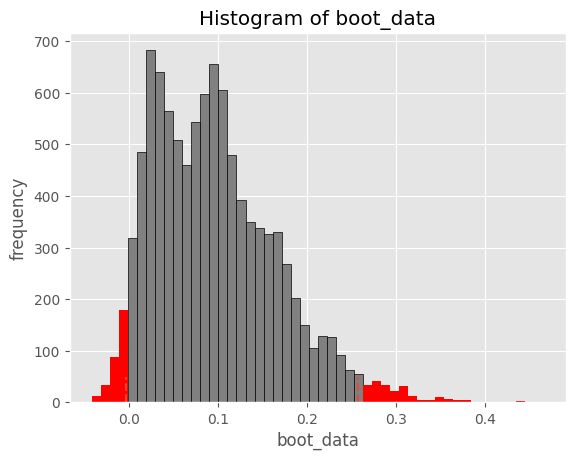

{'p_value': 0.16213002840700885}

In [29]:
get_bootstrap(df[(df['VARIANT_NAME'] == 'control')]['REVENUE'], df[(df['VARIANT_NAME'] == 'variant')]['REVENUE'])

### Расчет мощности теста

In [64]:
C_mean = control_visit_all.mean()
T_mean = test_visit_all.mean()

C_std = control_visit_all.std()
T_std = test_visit_all.std()

# Se = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))
Se = np.sqrt((T_std**2/n2) + (C_std **2/n1))

ef = float((T_mean-C_mean)/Se) 
alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(ef, power=None,
nobs1=n1, ratio=1.0, alpha=alpha)

result

1.0

# Результат
1. Нет созначимых различий между групами. 
2. Тестовая версия показывает себя по хуже Контрольной. Нет смысла выкатывать Тестовую версию.